In [1]:
import silence_tensorflow.auto
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import warnings

tfd = tfp.distributions
tfb = tfp.bijectors

plt.rcParams['figure.facecolor'] = '1.'


In [2]:
# Load the Radon dataset from `tensorflow_datasets` and filter to data from
# Minnesota.
dataset = tfds.as_numpy(
    tfds.load('radon', split='train').filter(
        lambda x: x['features']['state'] == 'MN').batch(10**9))

In [3]:
# Dependent variable: Radon measurements by house.
dataset = next(iter(dataset))
radon_measurement = dataset['activity'].astype(np.float32)
radon_measurement[radon_measurement <= 0.] = 0.1
log_radon = np.log(radon_measurement)

In [4]:
# Measured uranium concentrations in surrounding soil.
uranium_measurement = dataset['features']['Uppm'].astype(np.float32)
log_uranium = np.log(uranium_measurement)

In [5]:
# County indicator.
county_strings = dataset['features']['county'].astype('U13')
unique_counties, county = np.unique(county_strings, return_inverse=True)
county = county.astype(np.int32)
num_counties = unique_counties.size

In [6]:
# Floor on which the measurement was taken.
floor_of_house = dataset['features']['floor'].astype(np.int32)

# Average floor by county (contextual effect).
county_mean_floor = []
for i in range(num_counties):
  county_mean_floor.append(floor_of_house[county == i].mean())
county_mean_floor = np.array(county_mean_floor, dtype=log_radon.dtype)
floor_by_county = county_mean_floor[county]

In [7]:
# Create variables for fixed effects.
floor_weight = tf.Variable(0.)
bias = tf.Variable(0.)

# Variables for scale parameters.
log_radon_scale = tfp.util.TransformedVariable(1., tfb.Exp())
county_effect_scale = tfp.util.TransformedVariable(1., tfb.Exp())

In [8]:
# Define the probabilistic graphical model as a JointDistribution.
@tfd.JointDistributionCoroutineAutoBatched
def model():
    uranium_weight = yield tfd.Normal(0., scale=1., name='uranium_weight')
    county_floor_weight = yield tfd.Normal(
          loc = 0., scale = 1., name = 'county_floor_weight',
          )
    county_effect = yield tfd.Sample(
        tfd.Normal(loc = 0., scale = county_effect_scale),
        sample_shape = [num_counties], name = 'county_effect',
        )
    yield tfd.Normal(
      loc = (
          log_uranium * uranium_weight + floor_of_house * floor_weight
           + floor_by_county * county_floor_weight
           + tf.gather(county_effect, county, axis = -1)
           + bias
          ),
      scale = log_radon_scale[..., tf.newaxis],
      name = 'log_radon',
      )

# Pin the observed `log_radon` values to model the un-normalized posterior.
target_model = model.experimental_pin(log_radon=log_radon)

In [9]:
# Determine the `event_shape` of the posterior, and calculate the size of each
# `event_shape` component. These determine the sizes of the components of the
# underlying standard Normal distribution, and the dimensions of the blocks in
# the blockwise matrix transformation.
event_shape = target_model.event_shape_tensor()
flat_event_shape = tf.nest.flatten(event_shape)
flat_event_size = tf.nest.map_structure(tf.reduce_prod, flat_event_shape)

# The `event_space_bijector` maps unconstrained values (in R^n) to the support
# of the prior -- we'll need this at the end to constrain Multivariate Normal
# samples to the prior's support.
event_space_bijector = target_model.experimental_default_event_space_bijector()


In [10]:
base_standard_dist = tfd.JointDistributionSequential(
      [tfd.Sample(tfd.Normal(0., 1.), s) for s in flat_event_size])


In [11]:
operators = (
    (tf.linalg.LinearOperatorDiag,),  # Variance of uranium weight (scalar).
    (tf.linalg.LinearOperatorFullMatrix,  # Covariance between uranium and floor-by-county weights.
     tf.linalg.LinearOperatorDiag),  # Variance of floor-by-county weight (scalar).
    (None,  # Independence between uranium weight and county effects.
     None,  #  Independence between floor-by-county and county effects.
     tf.linalg.LinearOperatorDiag)  # Independence among the 85 county effects.
    )

block_tril_linop = (
    tfp.experimental.vi.util.build_trainable_linear_operator_block(
        operators, flat_event_size))
scale_bijector = tfb.ScaleMatvecLinearOperatorBlock(block_tril_linop)


In [12]:
loc_bijector = tfb.JointMap(
    tf.nest.map_structure(
        lambda s: tfb.Shift(
            tf.Variable(tf.random.uniform(
                (s,), minval=-2., maxval=2., dtype=tf.float32))),
        flat_event_size))

In [13]:
# Reshape each component to match the prior, using a nested structure of
# `Reshape` bijectors wrapped in `JointMap` to form a multipart bijector.
reshape_bijector = tfb.JointMap(
    tf.nest.map_structure(tfb.Reshape, flat_event_shape))

# Restructure the flat list of components to match the prior's structure
unflatten_bijector = tfb.Restructure(
        tf.nest.pack_sequence_as(
            event_shape, range(len(flat_event_shape))))


In [14]:
surrogate_posterior = tfd.TransformedDistribution(
    base_standard_dist,
    bijector = tfb.Chain(  # Note that the chained bijectors are applied in reverse order
        [
         event_space_bijector,  # constrain the surrogate to the support of the prior
         unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the posterior
         reshape_bijector,  # reshape the vector-valued components to match the shapes of the posterior components
         loc_bijector,  # allow for nonzero mean
         scale_bijector  # apply the block matrix transformation to the standard Normal distribution
         ]))


Multivariate Normal surrogate posterior ELBO: -1065.5272216796875


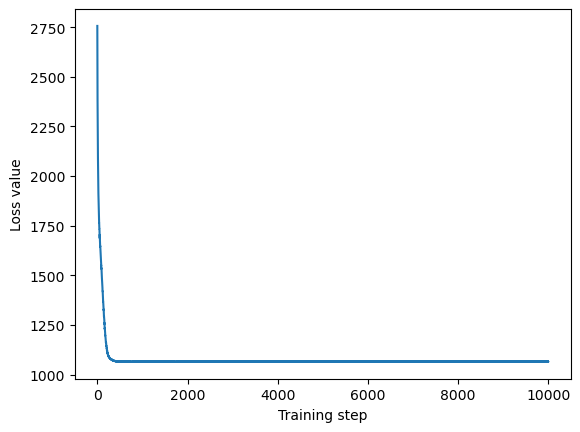

In [15]:
optimizer = tf.optimizers.Adam(learning_rate=1e-2)
mvn_loss = tfp.vi.fit_surrogate_posterior(
    target_model.unnormalized_log_prob,
    surrogate_posterior,
    optimizer=optimizer,
    num_steps=10**4,
    sample_size=16,
    )

mvn_samples = surrogate_posterior.sample(1000)
mvn_final_elbo = tf.reduce_mean(
    target_model.unnormalized_log_prob(*mvn_samples)
    - surrogate_posterior.log_prob(mvn_samples))

print('Multivariate Normal surrogate posterior ELBO: {}'.format(mvn_final_elbo))

plt.plot(mvn_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')


Bias is: 1.40
Floor fixed effect is: -0.72


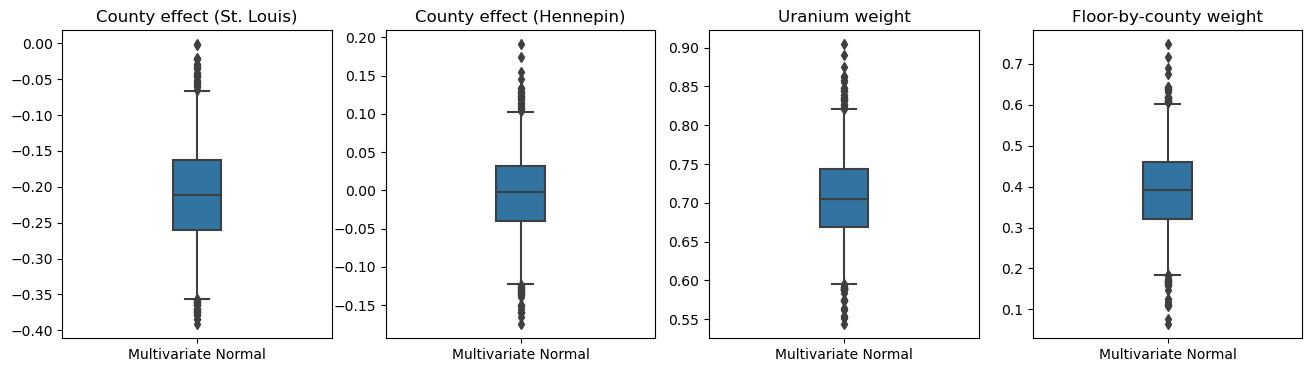

In [16]:
st_louis_co = 69  # Index of St. Louis, the county with the most observations.
hennepin_co = 25  # Index of Hennepin, with the second-most observations.

def pack_samples(samples):
  return {'County effect (St. Louis)': samples.county_effect[..., st_louis_co],
          'County effect (Hennepin)': samples.county_effect[..., hennepin_co],
          'Uranium weight': samples.uranium_weight,
          'Floor-by-county weight': samples.county_floor_weight}

def plot_boxplot(posterior_samples):
  fig, axes = plt.subplots(1, 4, figsize=(16, 4))

  # Invert the results dict for easier plotting.
  k = list(posterior_samples.values())[0].keys()
  plot_results = {
      v: {p: posterior_samples[p][v] for p in posterior_samples} for v in k}
  for i, (var, var_results) in enumerate(plot_results.items()):
    sns.boxplot(data=list(var_results.values()), ax=axes[i],
                width=0.18*len(var_results), whis=(2.5, 97.5))
    # axes[i].boxplot(list(var_results.values()), whis=(2.5, 97.5))
    axes[i].title.set_text(var)
    fs = 10 if len(var_results) < 4 else 8
    axes[i].set_xticklabels(list(var_results.keys()), fontsize=fs)

results = {'Multivariate Normal': pack_samples(mvn_samples)}

print('Bias is: {:.2f}'.format(bias.numpy()))
print('Floor fixed effect is: {:.2f}'.format(floor_weight.numpy()))
plot_boxplot(results)
